Init

In [97]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

transforms = transforms.Compose([transforms.ToTensor()])
mnist_dataset = datasets.MNIST(root='./data',train=True,download=True,transform=transforms)
device = torch.device("cuda" if torch.cuda.is_available() else "")
print(device)

cuda


Load Data

In [98]:
batch_size = 128
train_loader = DataLoader(dataset=mnist_dataset,batch_size=batch_size,shuffle=True,drop_last=True)
train_data_iter = iter(train_loader)
images = train_data_iter.__next__()
num_sampler = 25
sample_images = [images[0][i,0] for i in range(num_sampler)]
sample_image = sample_images[0]
image_size = sample_image.size()
x_dim = image_size[0] * image_size[1]
print(x_dim)

784


VAE Implementation

In [99]:
import torch.nn as nn
from torch.optim import Adam
from torch.utils.tensorboard import SummaryWriter
import time 
currentTime = time.strftime("%Y-%m-%d-%H_%M_%S", time.localtime(time.time()))
writer = SummaryWriter('./log/{currentTime}'.format(currentTime = currentTime))

class VAE(nn.Module):
    
    def __init__(self, input_dim:int = 28 * 28, hidden_dim:int = 400, latent_dim:int = 200, device:str = 'cuda'):
        super(VAE, self).__init__()
        
        # encoder产生z
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.LeakyReLU(0.2),
            nn.Linear(hidden_dim,latent_dim),
            nn.LeakyReLU(0.2),
        )
        # 然后产生p(z|x)的均值和方差
        # 图像是二维灰度图，所以方差和均值dim = 2
        self.mean_layer = nn.Linear(latent_dim, 2)
        self.log_var_layer = nn.Linear(latent_dim, 2)
        
        # 均值和方差与z的维度一致
        # self.mean_layer = nn.Linear(latent_dim, latent_dim)
        # self.log_var_layer = nn.Linear(latent_dim, latent_dim)
        
        # decoder根据p(x|z)产生新的采样
        self.decoder = nn.Sequential(
            nn.Linear(2, latent_dim),
            nn.LeakyReLU(0.2),
            nn.Linear(latent_dim, hidden_dim),
            nn.LeakyReLU(0.2),
            nn.Linear(hidden_dim, input_dim),
            nn.Sigmoid()
        )
        
    def encode(self, x):
        x = self.encoder(x)
        mean, log_var = self.mean_layer(x), self.log_var_layer(x)
        return mean, log_var
    
    def decode(self,x):
        return self.decoder(x)
    
    def reparameteriztion(self, mean, var):
        epsilon = torch.randn_like(var).to(device)
        z = mean + var * epsilon
        return z
    
    def forward(self, x):
        mean, log_var = self.encode(x)
        z = self.reparameteriztion(mean, log_var)
        x_hat = self.decode(z)
        return x_hat,mean,log_var

def loss_function(x, x_hat, mean, log_var):
    # 因为这个数据集的图形都是0/1，所以用交叉熵做Loss了
    reproductive_loss = nn.functional.binary_cross_entropy(x_hat, x, reduction='sum')
    # reproductive_loss = nn.functional.binary_cross_entropy(x_hat, x, reduction='mean')
    # reproductive_loss = nn.MSELoss(x_hat,x,reduction='sum')
    kld = -0.5 * torch.sum(1 + log_var - mean.pow(2) - log_var.exp())
    return reproductive_loss + kld

def train(model,optimizer,epochs,device):
    
    model.train()
    for epoch in range(epochs):
        print('Epoch: ',epoch)
        epoch_loss = 0
        for batch_idx, (data, target) in enumerate(train_loader):
            data = data.view(batch_size, x_dim).to(device)
            x_hat,mean,log_var = model(data)
            loss = loss_function(data, x_hat, mean, log_var)
            epoch_loss += loss
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        
        writer.add_scalar('loss/train', epoch_loss, epoch)
        print(epoch_loss)

    writer.close()
    
# train
model = VAE().to(device)
optimizer = Adam(model.parameters(), lr = 1e-4)
train(model, optimizer, epochs=100, device=device)

Epoch:  0
tensor(14529048., device='cuda:0', grad_fn=<AddBackward0>)
Epoch:  1
tensor(11103842., device='cuda:0', grad_fn=<AddBackward0>)
Epoch:  2
tensor(10363290., device='cuda:0', grad_fn=<AddBackward0>)
Epoch:  3
tensor(10040646., device='cuda:0', grad_fn=<AddBackward0>)
Epoch:  4
tensor(9836428., device='cuda:0', grad_fn=<AddBackward0>)
Epoch:  5
tensor(9710161., device='cuda:0', grad_fn=<AddBackward0>)
Epoch:  6
tensor(9622721., device='cuda:0', grad_fn=<AddBackward0>)
Epoch:  7
tensor(9554593., device='cuda:0', grad_fn=<AddBackward0>)
Epoch:  8
tensor(9496770., device='cuda:0', grad_fn=<AddBackward0>)
Epoch:  9
tensor(9446331., device='cuda:0', grad_fn=<AddBackward0>)
Epoch:  10
tensor(9395220., device='cuda:0', grad_fn=<AddBackward0>)
Epoch:  11
tensor(9345761., device='cuda:0', grad_fn=<AddBackward0>)
Epoch:  12
tensor(9294251., device='cuda:0', grad_fn=<AddBackward0>)
Epoch:  13
tensor(9242264., device='cuda:0', grad_fn=<AddBackward0>)
Epoch:  14
tensor(9191204., device='cuda

checkpoint

In [100]:
checkpoints_path = './checkpoints/'
checkpoint_name = f'{checkpoints_path}/{currentTime}.pt'
torch.save(model.state_dict(), checkpoint_name)

generate

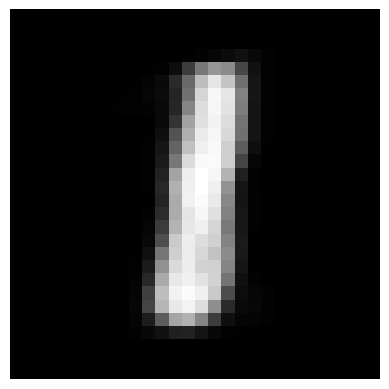

In [116]:
def generate_digit(mean, var):
    z_sample = torch.tensor([[mean, var]],dtype=torch.float).to(device)
    x_decoded = model.decode(z_sample)
    digit = x_decoded.detach().cpu().reshape(28, 28)
    plt.imshow(digit, cmap='grey')
    plt.axis('off')
    plt.show()
    
generate_digit(0.6,0.8)